In [75]:
#!/usr/bin/env python3
import pickle as pk
import sys
import time as tm
from argparse import ArgumentParser
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import FeatureAblation
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from torch.utils.data.dataset import Dataset

sns.set_theme()

In [76]:
class dataset_geno(Dataset):
    """a class for importing simulated genotype-phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_geno):
        self.datset = pk.load(open(data_file, "rb"))
        self.genotypes = torch.tensor(np.array(self.datset["genotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_geno = n_geno

    def __len__(self):
        return len(self.genotypes)

    def __getitem__(self, idx):
        genotypes = torch.flatten(self.genotypes[idx])
        return genotypes

In [77]:
n_geno = 4200
n_alleles = 2
latent_space_g = 4200
num_epochs_gen = 15


In [78]:
train_data_geno = dataset_geno('sim_2trait_dec20_train.pk', n_geno=n_geno)
test_data_geno = dataset_geno('sim_2trait_dec20_test.pk', n_geno=n_geno)


In [79]:
test_loader_geno = torch.utils.data.DataLoader(
    dataset=test_data_geno, batch_size=200, num_workers=1, shuffle=True
)


train_loader_geno = torch.utils.data.DataLoader(
    dataset=train_data_geno, batch_size=200, num_workers=1, shuffle=True
)


# define encoder/decoder architecture

In [80]:
# gencoder
class GQ_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=n_loci, out_features=N),
            nn.BatchNorm1d(N, momentum=0.8),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=g_latent_dim),
            nn.BatchNorm1d(g_latent_dim, momentum=0.8),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# gendecoder
class GP_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if N is None:
            N = latent_space_g
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = latent_space_g
        self.encoder = nn.Sequential(
            nn.Linear(in_features=g_latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=n_loci),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

GQ = GQ_net()
GP = GP_net()

GQ.to(device)
GP.to(device)

EPS = 1e-15
reg_lr = 0.00001
adam_b = (0.5, 0.999)

optim_GQ_enc = torch.optim.Adam(GQ.parameters(), lr=reg_lr, betas=adam_b)
optim_GP_dec = torch.optim.Adam(GP.parameters(), lr=reg_lr, betas=adam_b)


cuda


In [82]:
%%script false --no-raise-error



in_genos = pk.load(open('sim_2trait_dec18.pk','rb'))
in_genos = in_genos['genotypes']

# Convert to a PyTorch tensor
tensor = torch.tensor(in_genos)

# Sum across the first axis
summed_tensor = tensor.sum(dim=0)

# Flatten the summed tensor
pop_freqs = summed_tensor.flatten()

#calculated allele weights based on abundance
allele_weights = (3000-pop_freqs+EPS)/((pop_freqs+EPS)) #calculate relative allele freq of 1's in batch
#allele_weights = 1/((pop_freqs+EPS)/3000) #calculate relative allele freq of 1's in batch
#allele_weights.clamp_(min=1)

#plt.hist(allele_weights)



allele_weights = allele_weights.to(device)

In [83]:

# train genetic autoencoder
g_rcon_loss = []
start_time = tm.time()

gen_noise = 1 - 0.3
#gen_noise = 1 - 0.001

for n in range(num_epochs_gen):
    for i, (gens) in enumerate(train_loader_geno):
        batch_size = gens.shape[0]  # redefine batch size here to allow for incomplete batches

        # reconstruction loss
        GP.zero_grad()
        GQ.zero_grad()

        gens = gens[:, : n_geno*n_alleles]

        pos_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        neg_noise = np.random.binomial(1, gen_noise / 2, gens.shape)

        noise_gens = torch.tensor(
            np.where((gens + pos_noise - neg_noise) > 0, 1, 0), dtype=torch.float32
        )

        noise_gens = noise_gens.to(device)

        gens = gens.to(device)

        #batch_allele_freq = (1-gens.mean(dim=0)+EPS)/((gens.mean(dim=0)+EPS)) #calculate relative allele freq of 1's in batch

        #weights = torch.where(  #checks where input g tensor =1, if 1, then puts weight for 1, otherwise puts 1/weight for 0
        #    gens == 1,
        #    allele_weights,
        #    1/allele_weights)
        #weights = weights.to(device)

        #print(gens)
        #print(weights)


        #z_sample = GQ(noise_gens)
        z_sample = GQ(gens)
        X_sample = GP(z_sample)



        g_recon_loss = F.binary_cross_entropy(X_sample + EPS, gens + EPS) #, weight=weights)

        l1_reg = torch.linalg.norm(torch.sum(GQ.encoder[0].weight, axis=0), 1)
        l2_reg = torch.linalg.norm(torch.sum(GQ.encoder[0].weight, axis=0), 2)

        #g_recon_loss = g_recon_loss + l1_reg * 0.00001 + l2_reg * 0.00001
        g_recon_loss = g_recon_loss + l1_reg * 0 + l2_reg * 0
        g_rcon_loss.append(float(g_recon_loss.detach()))

        g_recon_loss.backward()
        optim_GQ_enc.step()
        optim_GP_dec.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(g_rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )


Epoch num: 0 batchno 12 r_con_loss: 0.7094231843948364 epoch duration: 1.433809518814087
Epoch num: 1 batchno 12 r_con_loss: 0.70307856798172 epoch duration: 1.4375252723693848
Epoch num: 2 batchno 12 r_con_loss: 0.6988810896873474 epoch duration: 1.4656579494476318
Epoch num: 3 batchno 12 r_con_loss: 0.6945291757583618 epoch duration: 1.4651365280151367
Epoch num: 4 batchno 12 r_con_loss: 0.6904513835906982 epoch duration: 1.4732680320739746
Epoch num: 5 batchno 12 r_con_loss: 0.686828076839447 epoch duration: 1.5700488090515137
Epoch num: 6 batchno 12 r_con_loss: 0.6834122538566589 epoch duration: 1.5122699737548828
Epoch num: 7 batchno 12 r_con_loss: 0.6799458265304565 epoch duration: 1.4939076900482178
Epoch num: 8 batchno 12 r_con_loss: 0.67683345079422 epoch duration: 1.5017776489257812
Epoch num: 9 batchno 12 r_con_loss: 0.6737257242202759 epoch duration: 1.4649333953857422
Epoch num: 10 batchno 12 r_con_loss: 0.6706392765045166 epoch duration: 1.456078052520752
Epoch num: 11 ba

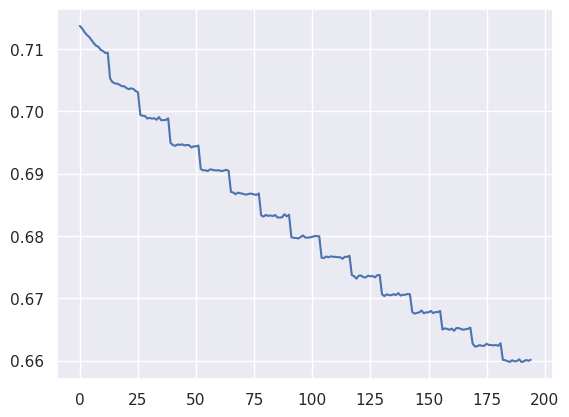

In [84]:
plt.plot(g_rcon_loss)

In [85]:
pred_gg = pd.DataFrame(X_sample.cpu().detach().numpy().T)
pred_gg_odd = pred_gg[1::2] #select only second position to easily tell if predicitng derived allele well

gens = gens.cpu()
gens_odd = gens[:, 1::2]


In [86]:

pred_gg_odd["samp1_rounded"] = (pred_gg_odd[0] / 1).round()
pred_gg_odd["samp2_rounded"] = (pred_gg_odd[1] / 1).round()
pred_gg_odd["samp3_rounded"] = (pred_gg_odd[2] / 1).round()
pred_gg_odd["samp4_rounded"] = (pred_gg_odd[3] / 1).round()


contingency_table = pd.crosstab(pred_gg_odd["samp1_rounded"], gens_odd[0])
print('\n',contingency_table)

contingency_table = pd.crosstab(pred_gg_odd["samp2_rounded"], gens_odd[1])
print('\n',contingency_table)


contingency_table = pd.crosstab(pred_gg_odd["samp3_rounded"], gens_odd[2])
print('\n',contingency_table)


contingency_table = pd.crosstab(pred_gg_odd["samp4_rounded"], gens_odd[3])
print('\n',contingency_table)



 col_0           0.0   1.0
samp1_rounded            
0.0            1274   829
1.0             812  1285

 col_0           0.0   1.0
samp2_rounded            
0.0            1250   830
1.0             810  1310

 col_0           0.0   1.0
samp3_rounded            
0.0            1349   759
1.0             811  1281

 col_0           0.0   1.0
samp4_rounded            
0.0            1289   835
1.0             793  1283


/tmp/ipykernel_66509/2711763276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_gg_odd["samp1_rounded"] = (pred_gg_odd[0] / 1).round()
/tmp/ipykernel_66509/2711763276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_gg_odd["samp2_rounded"] = (pred_gg_odd[1] / 1).round()
/tmp/ipykernel_66509/2711763276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Evaluate g-g on decoder

In [87]:

# test the g-g prediction
gen_encodings = []
phens = []
gen_latent = []
gen_original = []


GQ.eval()
GP.eval()

for dat in test_loader_geno:
    gt = dat
    gt = gt[:, : n_geno * n_alleles]
    gt = gt.to(device)
    batch_size = 10
    z_sample = GQ(gt)
    X_sample = GP(z_sample)
    gen_encodings += list(X_sample.detach().cpu().numpy())
    gen_latent += list(z_sample.detach().cpu().numpy())
    gen_original += list(gt.detach().cpu().numpy())


0.5159947382888777


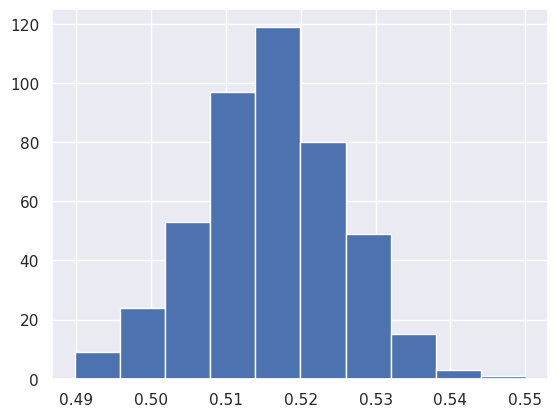

In [88]:
gen_encodings_odd = [array[1::2] for array in gen_encodings]
gen_original_odd = [array[1::2] for array in gen_original]

f1err = [(f1_score((gen_encodings_odd[n] / 1).round(), gen_original_odd[n])) for n in range(len(gen_original_odd[:len(gen_original_odd)]))]
plt.hist(f1err)
print(np.mean(f1err))

In [89]:
print(pd.crosstab((gen_encodings_odd[4] / 1).round(), gen_original_odd[4]))
print(f1_score((gen_encodings_odd[4] / 1).round(), gen_original_odd[4]))


col_0   0.0   1.0
row_0            
0.0    1061  1069
1.0     997  1073
0.5094966761633428


In [90]:
%%script false --no-raise-error






from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

full_data_geno = dataset_geno('sim_2trait_dec18.pk', n_geno=n_geno )


full_loader_geno = torch.utils.data.DataLoader(
    dataset=full_data_geno, batch_size=10, num_workers=1, shuffle=True
)

In [91]:
%%script false --no-raise-error





# visualise the g-g prediction on full dataset
gen_encodings = []
phens = []
gen_latent = []
gen_original = []


GQ.eval()
GP.eval()

for dat in full_loader_geno:
    gt = dat
    gt = gt[:, : 97323]
    gt = gt.to(device)
    batch_size = 10
    z_sample = GQ(gt)
    X_sample = GP(z_sample)
    gen_encodings += list(X_sample.detach().cpu().numpy())
    gen_latent += list(z_sample.detach().cpu().numpy())
    gen_original += list(gt.detach().cpu().numpy())

In [92]:
%%script false --no-raise-error



latent_df = pd.DataFrame(gen_latent)
latent_df

pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_df.values)
pca_result_df = pd.DataFrame(pca_result)
pca_result_df

In [93]:
#plt.figure(figsize=(5,5))
#sns.scatterplot(
#    x=pca_result_df[0], y=pca_result_df[1],
#    palette=sns.color_palette("hls", 10),
#    data=pca_result_df,
#    legend="full",
#    alpha=0.3
#)

In [94]:
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tsne_results = tsne.fit_transform(latent_df)
#tsne_results_df = pd.DataFrame(tsne_results)
#tsne_results_df

In [95]:
#plt.figure(figsize=(7,7))

#sns.scatterplot(
#    x=tsne_results_df[0], y=tsne_results_df[1],
#    palette=sns.color_palette("hls", 10),
#    data=tsne_results_df,
#    legend="full",
#    alpha=0.7
#)